In [1]:
import os
import math
import polars as pl
import hvplot
import hvplot.pandas
from hvplot.plotting import scatter_matrix
import matplotlib.pyplot as plt
from nrbdaq.instr.ae31 import AE31
from nrbdaq.instr.avo import compile_data as avo_compile_data
from nrbdaq.utils.utils import load_config
from nrbdaq.utils.sftp import SFTPClient

incoming = '/product_data/data/pay/Kenya/NRB/incoming'
processed = '/product_data/data/pay/Kenya/NRB/processed'

config = load_config('nrbdaq.yaml')
config['AE31']['data'] = os.path.join(incoming, 'ae31')
config['AE31']['archive'] = processed
ae31 = AE31(config=config)
df_ae31 = ae31.compile_data()

stations = ['kmd_hq_nairobi']#, 'huduma_center_bomet', 'mogogosiek_tea_factory_bomet']

avo = avo_compile_data(stations=stations, 
                    source=os.path.join(incoming, 'avo'), 
                    target=processed)

df_avo_daily = avo['kmd_hq_nairobi']['daily']
df_avo_hourly = avo['kmd_hq_nairobi']['hourly']
df_avo_instant = avo['kmd_hq_nairobi']['instant']

In [2]:
# aggregate AE31 data to hourly median values
df_ae31_hourly = df_ae31.sort(by='dtm').group_by_dynamic(index_column='dtm', every='1h', closed='right').agg(pl.all().exclude('dtm').median())
vars_ae31 = ['UV370', 'B470', 'G520', 'Y590', 'R660', 'IR880', 'IR950', ]
# convert from ng/m3 to µg/m3
df_ae31_hourly = df_ae31_hourly.with_columns(pl.col(vars_ae31) / 1000)

# sort AVO data by dtm
# df_avo_hourly = df_avo_hourly.sort(by='dtm')
vars_avo = ['pm1', 'pm25', 'pm10']

# combine data 
df = pl.concat([df_ae31_hourly.select(['dtm'] + vars_ae31), df_avo_hourly.select(['dtm'] + vars_avo)], how='align')

# Save results
df.write_parquet(file=os.path.join('results',  f"{stations[0]}.parquet"))

In [7]:
# Generate scatter matrix plot
df_pd = df.select(pl.exclude('dtm')).to_pandas()
figure = scatter_matrix(df_pd, alpha=0.2)
hvplot.show(figure)

# Save results
hvplot.save(obj=figure, filename=os.path.join('results', f"{stations[0]}_scatter_matrix.html"))

Launching server at http://localhost:39937


In [6]:
# Generate time series plot
df_pd = df.to_pandas()
color_ae31 = ['purple', 'darkblue', 'green', 'gold', 'red', 'black', 'brown']
color_avo = ['darkgray', 'gray', 'lightgray']

# get scaling factor for AVO data so that they can be plotted on the same graph as AE31 data
avo_max = max([df[x].max() for x in vars_avo]) # µg/m3
ae31_max = max([df[x].max() for x in vars_ae31]) # µg/m3
f = 10**round(math.log10(ae31_max / avo_max), 0)

df_pd[vars_avo] = f * df_pd[vars_avo]
vars_avo_new = [f"{x} [x {f}]" for x in vars_avo]
df_pd.rename(columns=dict(zip(vars_avo, vars_avo_new)), inplace=True)

# Plot time series
plot_ae31 = df_pd.hvplot(x='dtm', y=vars_ae31, color=color_ae31, legend=True, yaxis='left', 
                         width=1200, height=500, ylabel=f"Concentration [µg/m3]",
                         title='KMD HQ Nairobi, Dagoretti Corner')
plot_avo = df_pd.hvplot(x='dtm', y=vars_avo_new, color=color_avo, legend=True, yaxis='left')
figure = plot_ae31 * plot_avo
hvplot.show(figure)

# Save results
hvplot.save(obj=figure, filename=os.path.join('results', f"{stations[0]}_time_series.html"))

Launching server at http://localhost:46823


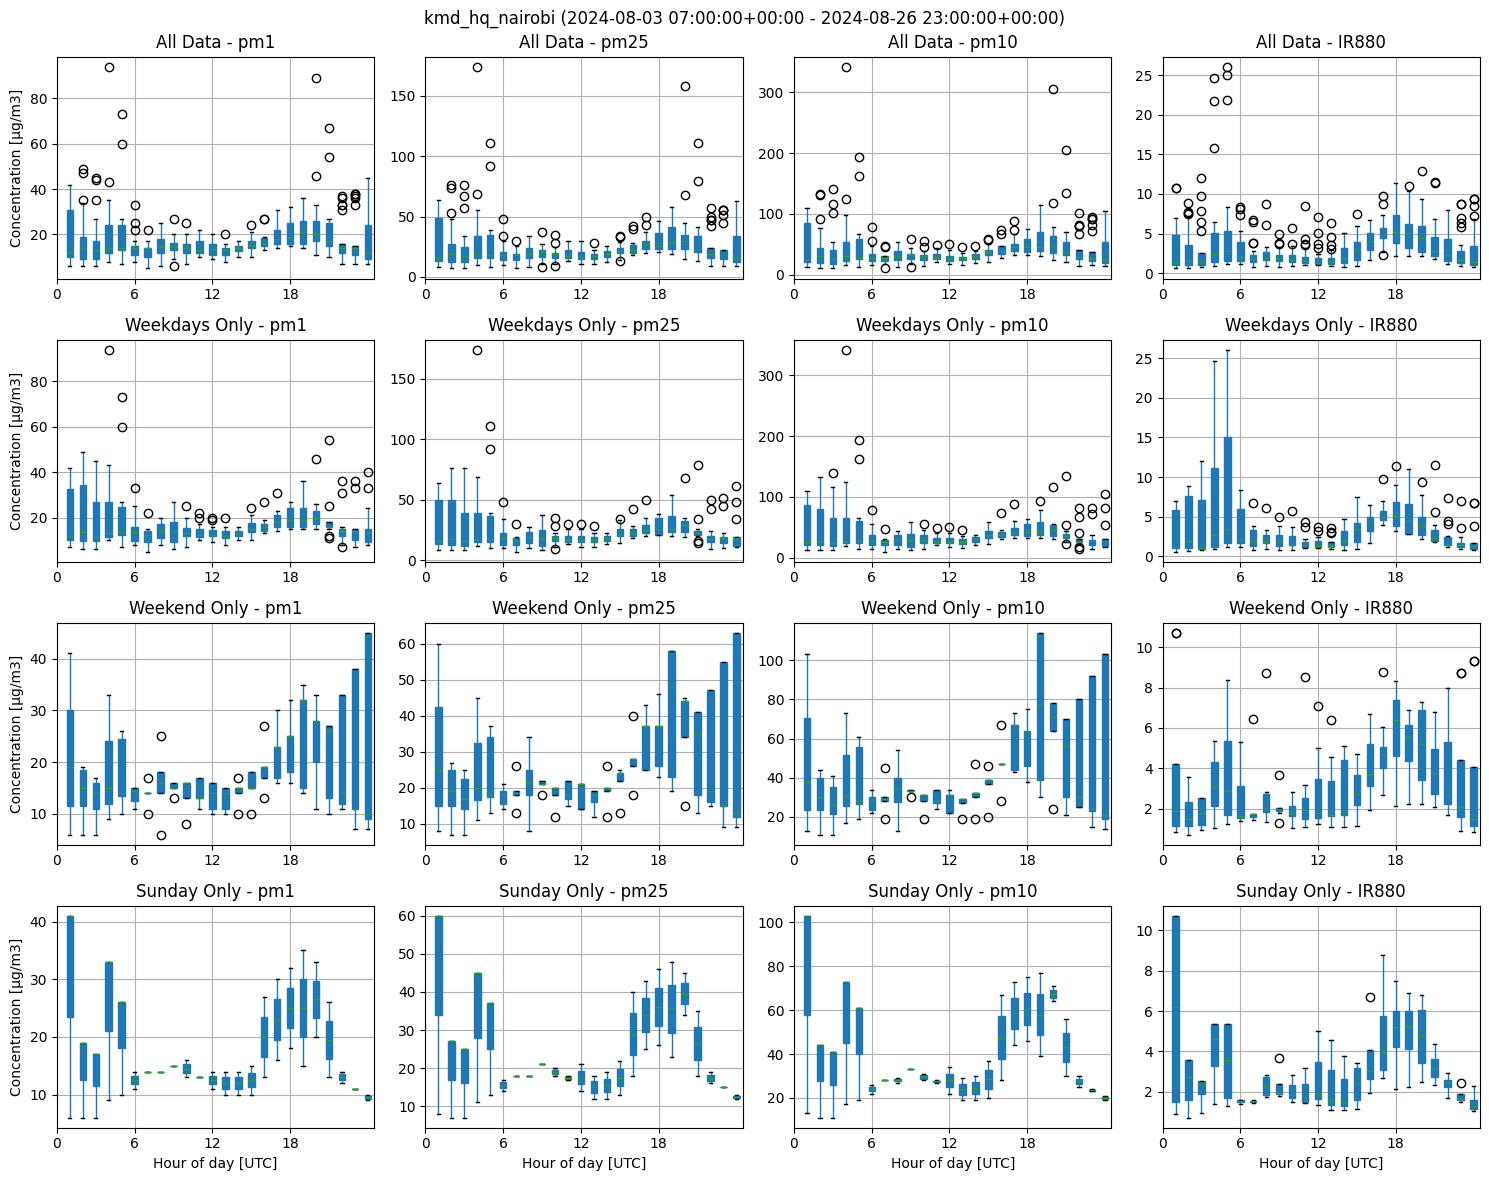

In [11]:
# Generate matrix of plots of diurnal variation

# Function to compute widths based on the number of data points per hour
# def compute_widths(hour_counts):
#     total_counts = sum(hour_counts)
#     return [10* count / total_counts for count in hour_counts]
# Function to compute widths based on the number of data points per hour and the number of days
# Function to compute widths based on the number of data points per hour, 
# the number of days, and the total number of data points
# def compute_widths(data, total_data_points, dtm='dtm'):
#     # Calculate the number of unique days in the current scenario
#     num_days = data.select(pl.col(dtm)).n_unique()
    
#     # Group by hour to calculate the number of data points in each hour
#     hour_counts = data.group_by('hour').agg(pl.len().alias('count'))
    
#     # Calculate the proportion of data points for each hour relative to the current scenario
#     total_scenario_points = hour_counts.select(pl.col('count')).sum()
#     hour_counts = hour_counts.with_columns(
#         (pl.col('count') / total_scenario_points).alias('relative_width_in_scenario')
#     )
    
#     # Scale the relative widths by the proportion of data points in the current scenario to the total data points
#     relative_scenario_proportion = total_scenario_points / total_data_points
#     hour_counts = hour_counts.with_columns(
#         (pl.col('relative_width_in_scenario') * relative_scenario_proportion).alias('final_width')
#     )
    
#     total_final_width = hour_counts.select(pl.col('final_width')).sum().item()
    
#     # Normalize the final widths so that they sum to 1
#     return (hour_counts['final_width'] / total_final_width).to_numpy()

# extract data period
start = df['dtm'].min()
end = df['dtm'].max()

# Extract the hour and the weekday
df_all = df.with_columns([
    pl.col('dtm').dt.hour().alias('hour'),
    pl.col('dtm').dt.weekday().alias('weekday')
])

# Define filters for the scenarios
# all_data = df
df_weekdays = df_all.filter(pl.col('weekday').is_between(0, 4))  # Monday to Friday
df_weekend = df_all.filter(pl.col('weekday').is_in([5, 6]))  # Saturday and Sunday
df_sunday = df_all.filter(pl.col('weekday') == 6)  # Sunday only

# Total number of data points across all scenarios
total_data_points = df_all.shape[0]

# Create box plots for each scenario
scenarios = {
    # "All Data": all_data,
    "All Data": df_all,
    "Weekdays Only": df_weekdays,
    "Weekend Only": df_weekend,
    "Sunday Only": df_sunday
}

fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4 scenarios, 4 columns

for i, (scenario_name, scenario_data) in enumerate(scenarios.items()):
    for j, col in enumerate(['pm1', 'pm25', 'pm10', 'IR880']):
        ax = axes[i, j]

        # widths = compute_widths(data, total_data_points=total_data_points)
        df_pd = scenario_data.to_pandas()
        
        # Create the box plot with proportional widths and light blue color
        # box = data.boxplot(column=col, by='hour', ax=ax, widths=10*widths, patch_artist=True)
        box = df_pd.boxplot(column=col, by='hour', ax=ax, patch_artist=True)
        # for patch in box['boxes']:
        #     patch.set_facecolor('lightblue')

        # Set the x-axis to only show labels for 0, 6, 12, 18 hours
        ax.set_xticks([0, 6, 12, 18])
        ax.set_xticklabels('')
        ax.set_xlabel('')
        ax.set_xticklabels(['0', '6', '12', '18'])

        ax.set_title(f'{scenario_name} - {col}')
        if i == 3:
            ax.set_xlabel('Hour of day [UTC]')
            # ax.set_xticklabels(['0', '6', '12', '18'])
        if j == 0:
            ax.set_ylabel(f'Concentration [µg/m3]')
        plt.suptitle(f"{stations[0]} ({start} - {end})")

plt.tight_layout()

# Save results
plt.savefig(os.path.join('results', f"{stations[0]}_diurnal_variation.png"))

# Show plot
plt.show()

# Return the filtered data
filtered_data = {
    "all_data": df_all,
    "df_weekdays": df_weekdays,
    "df_weekend": df_weekend,
    "df_sunday": df_sunday
}

In [ ]:
# import polars as pl
# import hvplot.pandas  # Ensure hvplot is imported as part of pandas
# import pandas as pd

# # Convert the Polars DataFrame to Pandas
# # df = df.to_pandas()

# # Extract the hour and weekday from the datetime column
# df['hour'] = df['dtm'].dt.hour
# df['weekday'] = df['dtm'].dt.weekday
# df['date'] = df['dtm'].dt.date  # Extract date to calculate the number of days

# # Define scenarios
# scenarios = {
#     "All Data": df,
#     "Weekdays Only": df[df['weekday'].between(0, 4)],  # Monday to Friday
#     "Weekend Only": df[df['weekday'].isin([5, 6])],  # Saturday and Sunday
#     "Sunday Only": df[df['weekday'] == 6]  # Sunday only
# }

# # Total number of data points across all scenarios
# total_data_points = df.shape[0]

# # Function to compute widths proportional to the number of data points
# def compute_widths(data, total_data_points):
#     # Count the number of unique days in the scenario
#     num_days = data['date'].nunique()
    
#     # Group by hour and count the occurrences
#     hour_counts = data.groupby('hour').size()
    
#     # Proportion of data points for each hour within the current scenario
#     total_scenario_points = hour_counts.sum()
#     relative_width_in_scenario = hour_counts / total_scenario_points
    
#     # Scale by the total data points proportion for the scenario
#     relative_scenario_proportion = total_scenario_points / total_data_points
#     final_widths = relative_width_in_scenario * relative_scenario_proportion
    
#     return final_widths

# # Plotting
# plots = []

# for scenario_name, scenario_data in scenarios.items():
#     widths = compute_widths(scenario_data, total_data_points)
    
#     # Create a box plot for each column
#     for col in ['pm1', 'pm25', 'pm10', 'IR880']:
#         plot = scenario_data.hvplot.box(
#             y=col, by='hour', width=800, height=400,
#             xlabel='Hour', ylabel=f'{col} Values',
#             title=f'{scenario_name} - {col}',
#             box_width=widths.to_dict()  # Pass the calculated widths
#         )
#         plots.append(plot)

# # Combine the plots vertically
# # hvplot.show(hvplot.Layout(plots).cols(1))
